In [1]:
from __future__ import division

from IPython.display import Image
from IPython.display import display
from pprint import pprint
from sklearn import tree
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals.six import StringIO
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import Imputer
import json
import numpy as np
import sklearn
import subprocess
import sys
import pickle

# Load data

In [2]:
basePath = "/mfs/replicated/tivvit/externalImages/"
_imgsProperties = pickle.load(open(basePath + "img_prop.pkl", "rb"))
_imgsResults = pickle.load(open(basePath + "img_res.pkl", "rb"))

In [3]:
class Learner:
    def vectorize(self, listOfDicts):
        vec = DictVectorizer()
        ldArray = vec.fit_transform(listOfDicts).toarray()
        ldArray = Imputer().fit_transform(ldArray)
        ldNames = np.asarray(vec.get_feature_names())
        return ldNames, ldArray

    def makeDecisionTree(self, X, Y):
        clf = tree.DecisionTreeClassifier(criterion='entropy', splitter='best',
                                          max_depth=4, min_samples_split=100,
                                          min_samples_leaf=20)
        clf = clf.fit(X, Y)
        return clf
    
    def makeForest(self, X, Y):
        clf = RandomForestClassifier(n_estimators=10, criterion='gini',
                                     max_depth=None, min_samples_split=2,
                                     min_samples_leaf=1,
                                    )
        clf = clf.fit(X, Y)
        return clf

    def displayDescisionTree(self, tree, XNames, YNames, fileName):
        dot_data = StringIO()
        with open(fileName + ".dot", "w") as f:
            sklearn.tree.export_graphviz(tree, out_file=f,
                                         feature_names=XNames,
                                         #class_names=list(YNames)
                                         )
        command = ["dot", "-Tpng", fileName + ".dot", "-o", fileName + ".png"]
        subprocess.check_call(command)

        display(Image(fileName + ".png", embed=True))
        
    def splitter(self, XArray, YArray):
        stratifiedSplit = StratifiedShuffleSplit(YArray,
                                                 test_size=0.2,
                                                 random_state=0)

        for train_index, test_index in stratifiedSplit:
            X_train, X_test = XArray[train_index], XArray[test_index]
            y_train, y_test = YArray[train_index], YArray[test_index]

        return X_train, y_train, X_test, y_test

    def test(self, tree, XA_test, YA_test, YNames):
        prediction = tree.predict(XA_test)
        print(classification_report(YA_test,
                                    prediction,
                                    target_names=YNames))
    
    def prepareYArray(self, array):
        return np.array([np.where(r == 1)[0][0] for r in array])

# Filter data (example)

In [4]:
imgsProperties = [x for i, x in enumerate(_imgsProperties) if _imgsResults[i]["class"] != "Mix"]
imgsResults = filter(lambda x: x["class"] != "Mix", _imgsResults)

In [5]:
imgsProperties[0]

{u'AC_depth': 1,
 u'AC_entropy': 0.0,
 u'AC_kurtosis': 0.0,
 u'AC_maxima': 0.0,
 u'AC_mean': 0.0,
 u'AC_minima': 0.0,
 u'AC_skewness': 0.0,
 u'AC_standard_deviation': 0.0,
 u'AC_sum': 0.0,
 u'AC_sum_cubed': 0.0,
 u'AC_sum_fourth_power': 0.0,
 u'AC_sum_squared': 0.0,
 u'AC_variance': 0.0,
 u'BR_128B_colorCnt': 0,
 u'CB_depth': 1,
 u'CB_entropy': 0.48341203401209426,
 u'CB_kurtosis': 4.676986139912417,
 u'CB_maxima': 1.0,
 u'CB_mean': 0.8953993055555556,
 u'CB_minima': 0.0,
 u'CB_skewness': -2.5839864821456997,
 u'CB_standard_deviation': 0.30603821520552693,
 u'CB_sum': 0.8953993055555556,
 u'CB_sum_cubed': 0.8953993055555586,
 u'CB_sum_fourth_power': 0.8953993055555675,
 u'CB_sum_squared': 0.8953993055555556,
 u'CB_variance': 0.8953993055555556,
 u'CG_depth': 1,
 u'CG_entropy': 0.48341203401209426,
 u'CG_kurtosis': 4.676986139912417,
 u'CG_maxima': 1.0,
 u'CG_mean': 0.8953993055555556,
 u'CG_minima': 0.0,
 u'CG_skewness': -2.5839864821456997,
 u'CG_standard_deviation': 0.306038215205526

In [6]:
imgsResults[:4]

[{'class': u'Graphics'},
 {'class': u'Graphics'},
 {'class': u'Graphics'},
 {'class': u'Graphics'}]

# Vectorize

In [7]:
learner = Learner()
XNames, XArray = learner.vectorize(imgsProperties)
YNames, YArray = learner.vectorize(imgsResults)
YArray = learner.prepareYArray(YArray)

# Split

In [8]:
XA_train, YA_train, XA_test, YA_test = learner.splitter(XArray, YArray)
print(XA_train.shape, YA_train.shape, XA_test.shape, YA_test.shape)

((15324, 142), (15324,), (3832, 142), (3832,))


# Learn

In [9]:
classifier = learner.makeDecisionTree(XA_train, YA_train)
#classifier = learner.makeForest(XA_train, YA_train)

# Test

In [10]:
learner.test(classifier, XA_test, YA_test, YNames)

                precision    recall  f1-score   support

class=Graphics       0.92      0.90      0.91      1897
  class=Photos       0.90      0.92      0.91      1935

   avg / total       0.91      0.91      0.91      3832



# Display

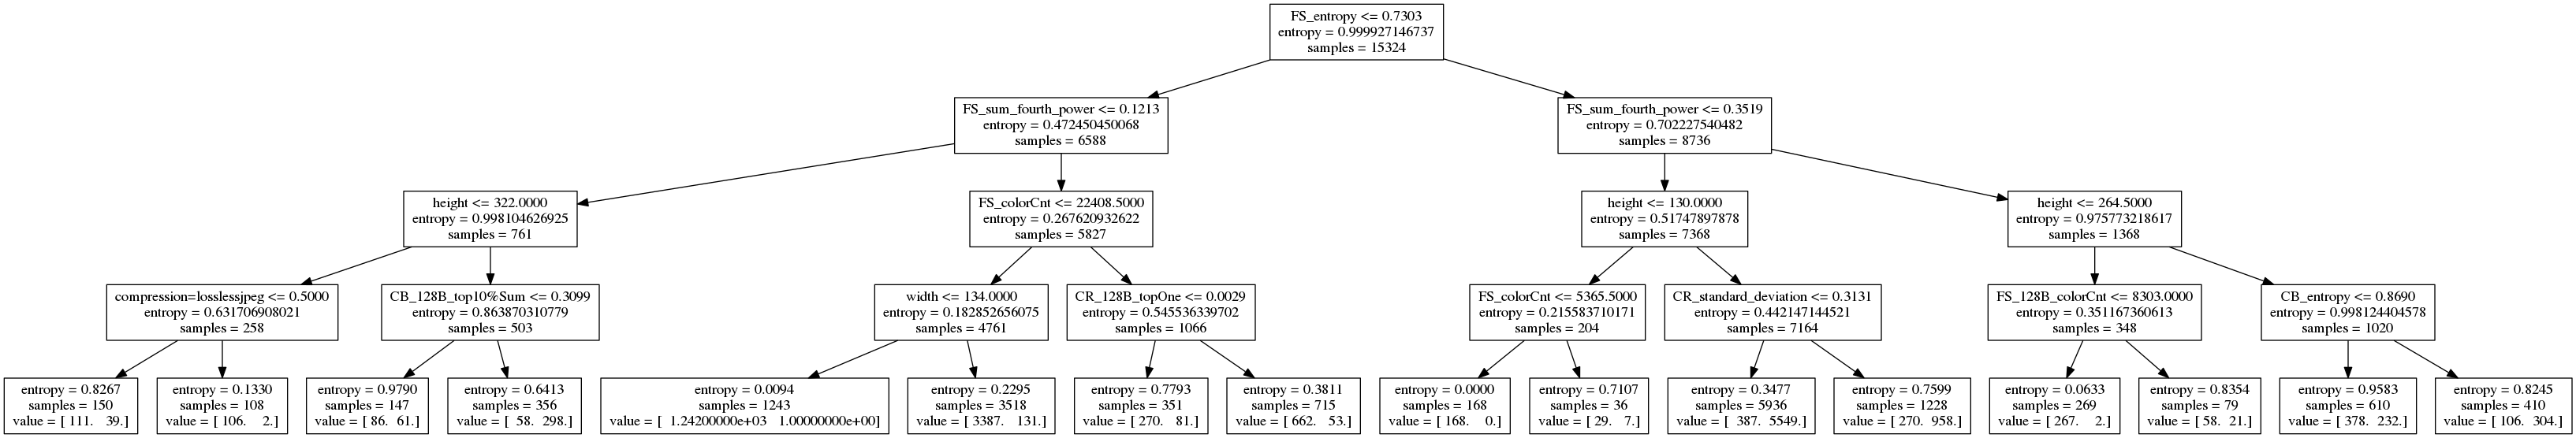

In [11]:
learner.displayDescisionTree(classifier, XNames, YNames, "tree")